# Dynamic programming on tree decompositions

We can apply dynamic programming on a graph of bounded treewidth (that is, a graph for which the treewidth is small) using the tree decomposition of said graph. Similarly to what we have done on trees, we need to build dynamic programming tables. However, instead of having dynamic programming tables based on the nodes of the tree, this time we have dynamic programming tables based on the bags of the tree decomposition. So, each bag will be associated to a table which is exponential in the number of the nodes contained in said bag. If the bag is $X = \left\{1, 2, 3 \right\}$ we need to create a table with the following entries: $\left\{\emptyset \right\}$, $\left\{1 \right\}$, $\left\{2 \right\}$, $\left\{3 \right\}$, $\left\{1, 2 \right\}$, $\left\{1, 3 \right\}$, $\left\{2, 3 \right\}$, $\left\{1, 2, 3 \right\}$. 

Using the usual bottom-up dynamic programming approach, we build the tables and perform the required computations until we reach the root of the tree decomposition. This time, differently from the way we do it on a tree, we will need to explicitly take care of devising a solution for the nodes at the intersection between two adjacent bags. In fact, if we consider the nodes in a bag as a small almost independent sub-problem, the nodes at the intersection between a parent bag and a child bag represent the nodes which do not make the bags fully independent. So we will need to devise a solution that account for those nodes at the intersection. The final solution to our problem will be, again, contained in the tables associated with the root bag.

Let's continue with the maximum independent set. This time we are going to implement a function to compute the maximum independent set on a generic graph, using a tree decomposition. For a bag $X_i$ of the tree decomposition, let $D_i$ be the union of the bags $X_{j}$ descending from $X_i$. For each independent set $S \subset X_i$ the table $A[S,i]$ will contain the size of the largest independent set $I \subset D_i$ such that $I \cap X_i = S$. Similarly, for each couple of adjacent (i.e. connected with a link) bags $X_i, X_k$ such that $X_i$ is the successor of $X_k$ and for an independent set $S \subset X_i \cap X_k$, the table $B[S,i,j]$ will contain the size of the largest independent set $I \subset D_i$ such that $I \cap X_i \cap X_k = S$.

In sum, for each node $X_i$ of the tree decomposition, we compute the following dynamic programming tables:
$$
A\left[ S,i \right] = \left| S \right| + \sum_j B \left[ S \cap X_j,j \right] - \left| S \cap X_j \right| \\
B\left[ S,i \right] = \max_{S' \subset X_i \atop S = S' \cap X_k} A[S', i]
$$

As we did for the MIS on trees, we will root the tree decomposition on a random bag and we will compute the aforementioned values by visiting the bags of the tree decomposition in postorder. This time we will need to know also the predecessors of the bags.

The function to compute the MIS on a graph $G$ takes in input the graph $G$ itself and its tree decomposition $T$. We will need to check if a subset of nodes is an independent set, so we will also write a function that checks whether a set is independent or not. To check if a set of nodes $S$ is independent we just have to check that there is no edge between any two nodes in $S$. The Maximum Independent Set of the graph $G$, given a tree decomposition $T$, once we computed the tables is defined as follows:
$$
MIS(G) = \max_{S \subset R} B[S, R]
$$

In [298]:
from itertools import combinations, permutations
import networkx as nx
from random import randint



# This function returns a generator to the powerset of S

def powerset(S):

    N = len(S) + 1

    for i in range(N):

        for subset in combinations(S, i):

            yield frozenset(subset)



# A function to check that a given set S is an independent set in the graph G
# A set S is an independent set if no two nodes in S are connected by an edge
def is_independent_set(S, G):

    assert all([node in G.nodes() for node in S]), "The nodes in S must be in G"

    for u, v in permutations(S, 2):
        if (u, v) in G.edges() or (v, u) in G.edges():
            # print(f"({u}, {v}) is an edge in G")
            return False

    return True



def MIS_with_tree_decomposition(G, T: nx.graph.Graph):

    from random import randint
    # Your code here!
    # Stampa Nodi partendo dalle foglie
    # Prendiamo l'ordine ivnerso degli elementi

    # La root va presa random
    indiceRoot = randint(0, len(list(T.nodes()))-1)
    root = list(T.nodes())[indiceRoot]

    postorder = list(nx.dfs_postorder_nodes(T, root))

    print(f"### Root Node: {list(T.nodes())[indiceRoot]}###")
    # Ora, mi servono due insiemi, A e B.
    A = {}
    B = {}

    bags = list(T.nodes())

    ## Rooting the Tree Decomposition T to the first node
    #root = list(T.nodes())[0]

    ## We need to know both successors and predecessors of each bag
    #successors = nx.dfs_successors(T, root)
    
    ## DFS Postorder
    #postorder = nx.dfs_postorder_nodes(T, root)

    # Va specificata la root prima altirmenti network x prende quello che vuole lui
    predecessors = nx.dfs_predecessors(T, root)


    for bag in postorder:
        # print(f"Controlliamo {bag}")
        # Calcoliamo il predecessore

        # Predecessore del bag
        if bag != root:
            pred = list(predecessors[bag])
            # print(f"Pred: {pred}")
        else:
            pred = None

        #print(f"Predecessore di {bag} --> {pred}")

        # Prendiamo per questa bag i subset
        subset = list(powerset(bag))
        
        independ = []
        # Rimuoviamo da questo subset quelli che non sono indipendenti
        for s in subset:
            # print(f"Controlliamo il subset {s}")
            if  is_independent_set(s, G):
                independ.append(s)
            

        # print(f"Gli indipendenti sono: {independ}")
        # Inizializzo A[bag]
        A[bag] = {}
        B[bag] = {}

        figli = nx.dfs_successors(T, root)
        if bag in figli.keys():
            #print(f"Figli di {bag}: {figli[bag]}")
            for s in independ:
                # to do calculation
                valore_len = len(s)
                #per ogni figlio
                val_figli = 0
                for c in figli[bag]:
                    #Intersezione tra il bag s e il figlio c
                    inter = s.intersection(c)
                    #print(f"Intersezione tra {s} e {c}: {inter}")
                    # Se la chiave non eisste, è 0
                    try:
                        val_figli += B[c][inter] - len(inter)
                    except:
                        val_figli += 0 
                A[bag][s] = valore_len + val_figli
        else:
            for s in independ:
                valore_len = len(s)
                A[bag][s] = valore_len
        
        # Stampiamo A[bag]
        # print(f"A[{bag}]: {A[bag]}")

        # Per B è il massimo tra i subset che intersecati con il padre hanno il valore
        # di A massimizzato
        #B[bag] = A[bag]
        if bag == root:
            B[bag] = A[bag]
            continue

        intersezioni = {}
        for k in A[bag].keys():
            if pred == None:
                pred = frozenset()
            inters = frozenset(set(k).intersection(pred))
            intersezioni[k] = inters

        for k in intersezioni.values():
            #Tutte le chiavi che hanno come valore k
            chiavi = [key for key, value in intersezioni.items() if value == k]
            # print(f"Chiavi che hanno come valore {k}: {chiavi}")
            #Prendo il massimo tra le chiavi in A
            val_A = [A[bag][key] for key in chiavi]
            # print(f"val_A: {val_A}")
            max_A = max(val_A)
            B[bag][k] = max_A

        print("             ")

    #Ci serve il valore massimo che c'è in B dell'albero
    # MIS(G) = max(B[root])
    max_B = max(B[root].values())
    print(f"Massimo di B[root]: {max_B}")


    # Prendiamo tutti i valori tali per cui B di ogni bag è il massimo di quel set
    nodi_massimi = {}

    # Per ogni bag, stampare la lista di nodi che massimizzano il valore di B per quel bag
    for b in reversed(postorder):
        val_max = max(B[b].values())
        print(f"Valore massimo di B[{b}]: {val_max}")
        nodi_massimi[b] = []
        # Prendiamo tutti i valori tali per cui B di ogni bag è il massimo di quel set
        for key, value in B[b].items():
            if value == val_max:
                nodi_massimi[b].append(key)
        
        print(f"Nodi massimi[b]: {nodi_massimi[b]}")
        print("             ")

    # Stampa finale
    print("             ")
    
    print(f"Nodi massimi: {nodi_massimi}")



   
    return max_B

    

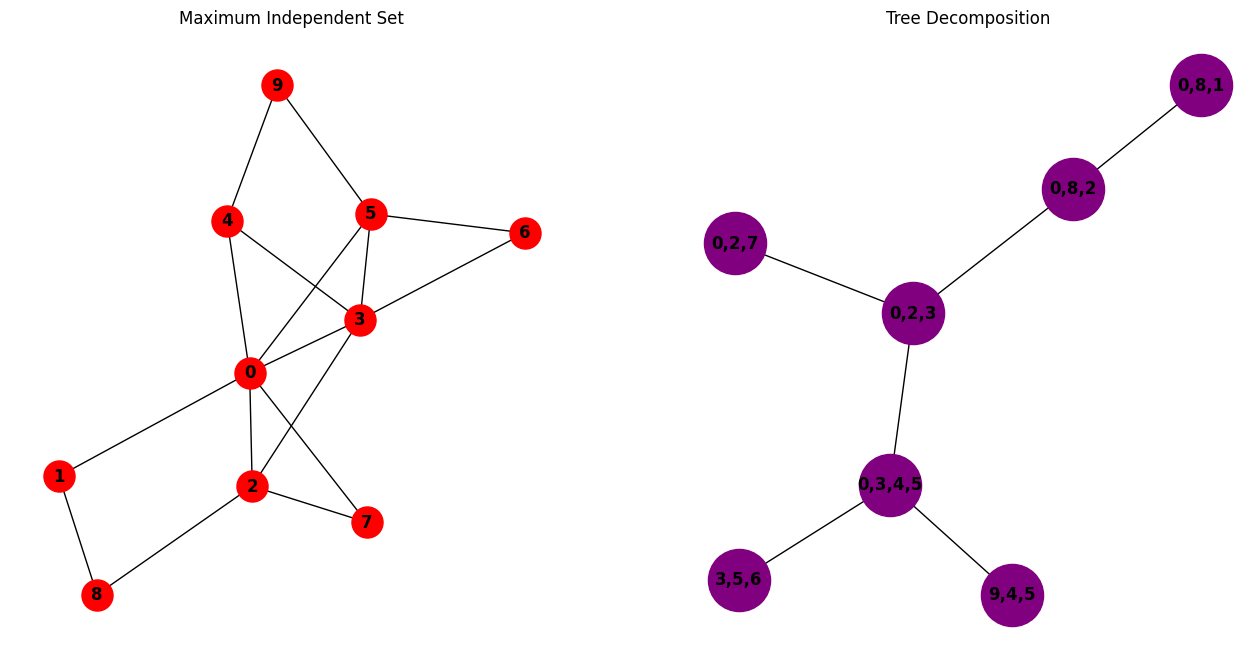

### Root Node: frozenset({0, 3, 4, 5})###
             
             
             
             
             
             
Massimo di B[root]: 4
Valore massimo di B[frozenset({0, 3, 4, 5})]: 4
Nodi massimi[b]: [frozenset(), frozenset({0}), frozenset({3}), frozenset({4}), frozenset({4, 5})]
             
Valore massimo di B[frozenset({3, 5, 6})]: 1
Nodi massimi[b]: [frozenset(), frozenset({3}), frozenset({5})]
             
Valore massimo di B[frozenset({9, 4, 5})]: 2
Nodi massimi[b]: [frozenset({4, 5})]
             
Valore massimo di B[frozenset({0, 2, 3})]: 3
Nodi massimi[b]: [frozenset({3})]
             
Valore massimo di B[frozenset({0, 2, 7})]: 1
Nodi massimi[b]: [frozenset(), frozenset({0}), frozenset({2})]
             
Valore massimo di B[frozenset({0, 8, 2})]: 2
Nodi massimi[b]: [frozenset({0}), frozenset({2})]
             
Valore massimo di B[frozenset({0, 8, 1})]: 2
Nodi massimi[b]: [frozenset({0, 8})]
             
             
Nodi massimi: {frozenset({0, 3, 4, 5}): 

In [302]:
import matplotlib.pyplot as plt

G = nx.Graph(
    [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (1, 8), (2, 3),
     (2, 7), (2, 8), (3, 4), (3, 5), (3, 6), (4, 9), (5, 6), (5, 9)], 
)

w, T = nx.approximation.treewidth_min_degree(G)

# Split window in 2 for nx.draw G and T

plt.figure(figsize=(16, 8))

plt.subplot(121)
# Title
plt.title("Maximum Independent Set")
nx.draw(G, with_labels = True, font_weight='bold', node_size = 500, node_color = 'red')
plt.subplot(122)

plt.title("Tree Decomposition")
labels = {node:','.join(list(map(str, node))) for node in T}
nx.draw(T, with_labels = True, labels=labels,font_weight='bold', node_size = 2000, node_color = 'purple')
plt.show()


# It should print 4
print(MIS_with_tree_decomposition(G, T))